In [1]:
import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *

In [2]:
fullPitch = 128
_, _, length, reducedPitch = (0,0,96,60)

# CDVAE

In [3]:
from utils.CDVAE import CDVAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CDVAE().to(device)
#print(model)

In [4]:
#LOAD MODEL
pathToModel = 'model/YamahaPianoCompetition2002Transposedby60_10Epochs.model'

try:
    #LOAD TRAINED MODEL INTO GPU
    if(torch.cuda.is_available()):
        model = torch.load(pathToModel)
        
    #LOAD MODEL TRAINED ON GPU INTO CPU
    else:
        model = torch.load(pathToModel, map_location=lambda storage, loc: storage)
    print("\n--------model restored--------\n")
except:
    print("\n--------no saved model found--------\n")

print('')


--------model restored--------




In [5]:
np.set_printoptions(precision=2, suppress=True, threshold=np.inf)


INPUT


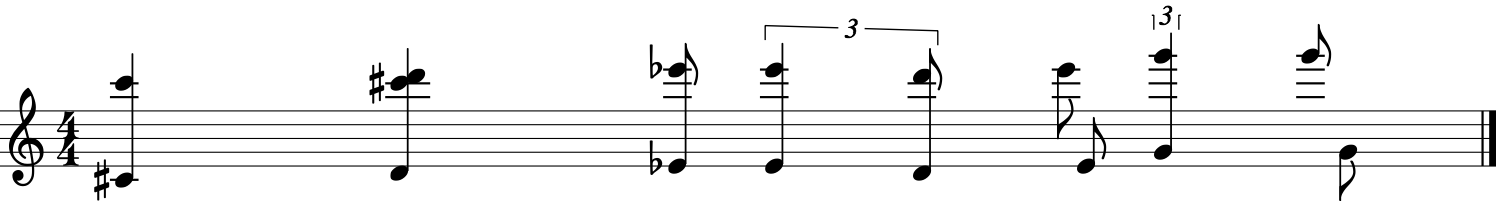

RECONSTRUCTION


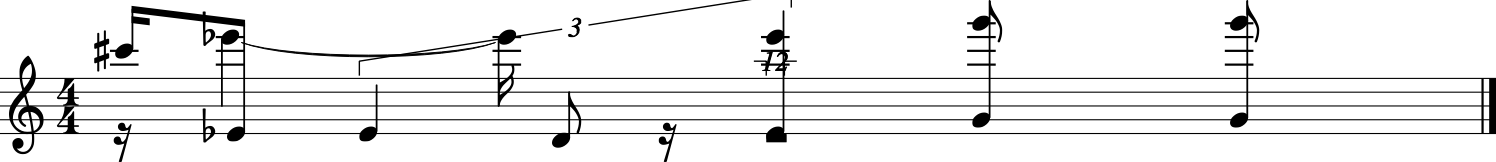

RANDOM NOISE WITH SAME MEAN and VARIANCE


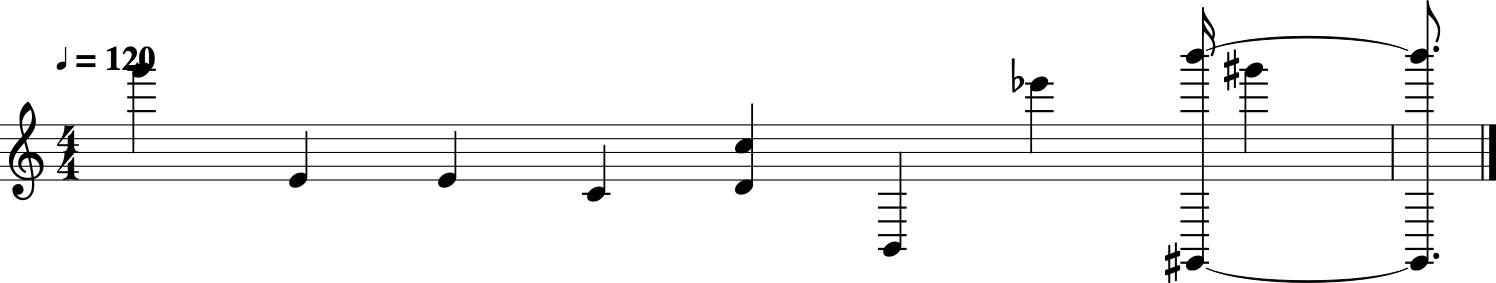




INPUT


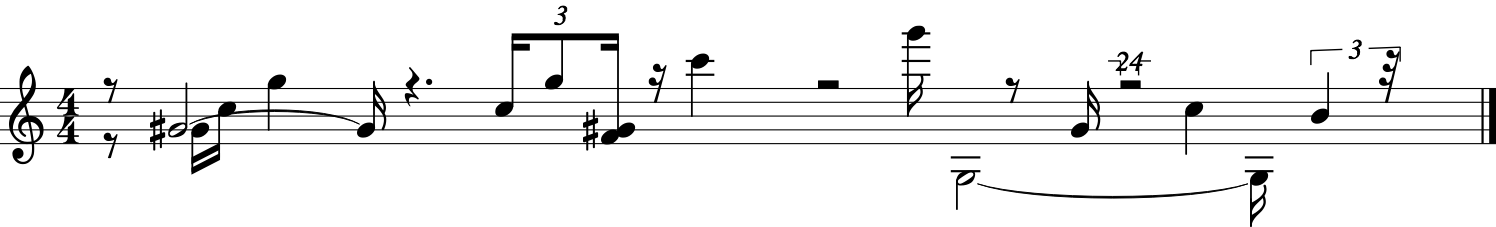

RECONSTRUCTION


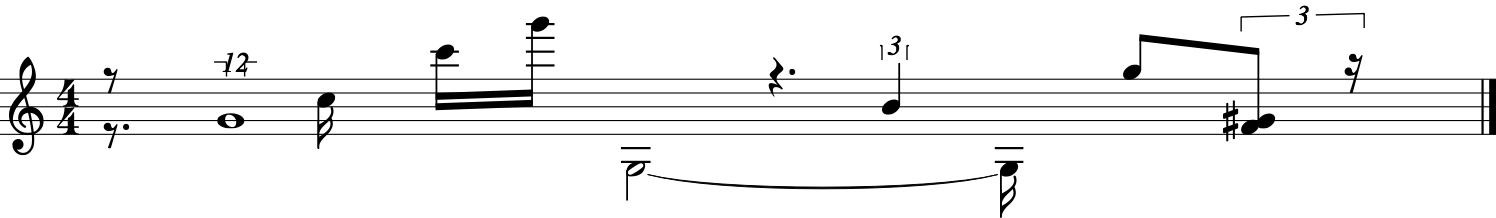

RANDOM NOISE WITH SAME MEAN and VARIANCE


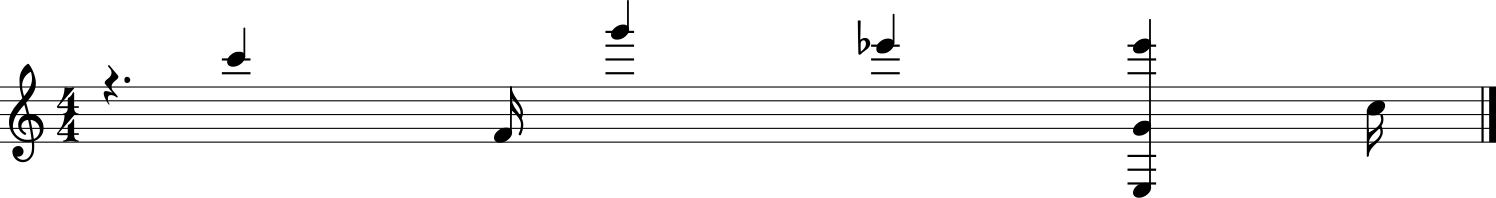




INPUT


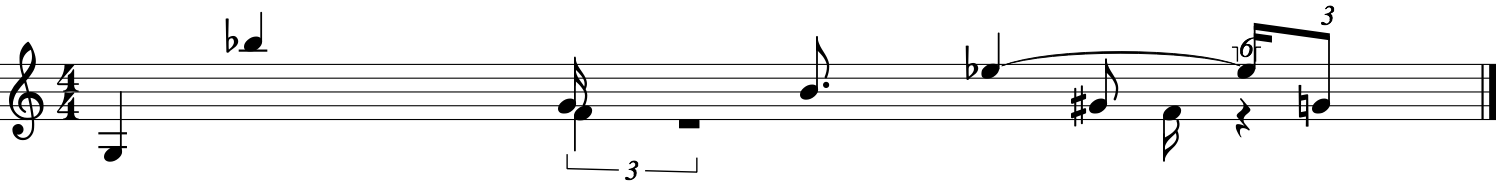

RECONSTRUCTION


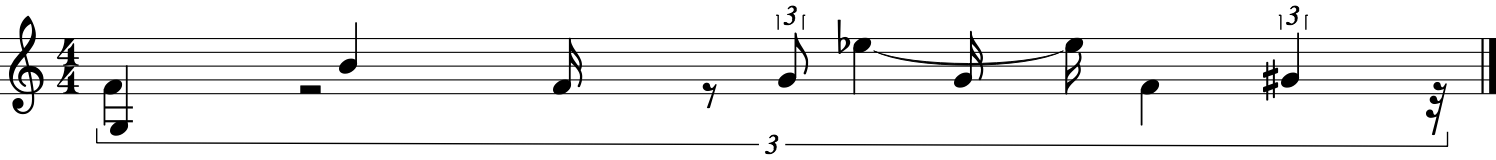

RANDOM NOISE WITH SAME MEAN and VARIANCE


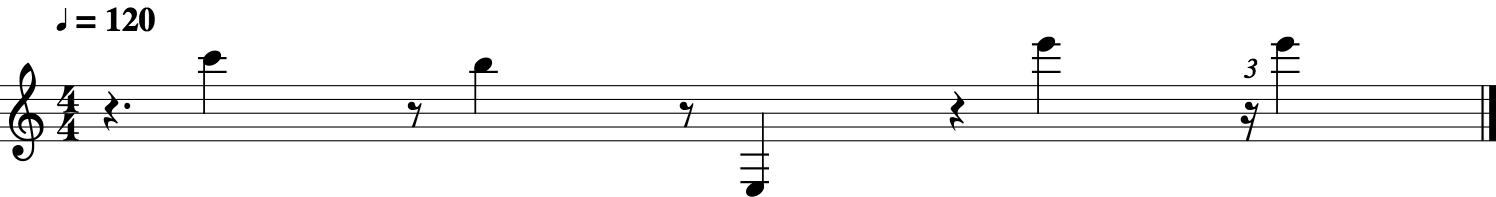




INPUT


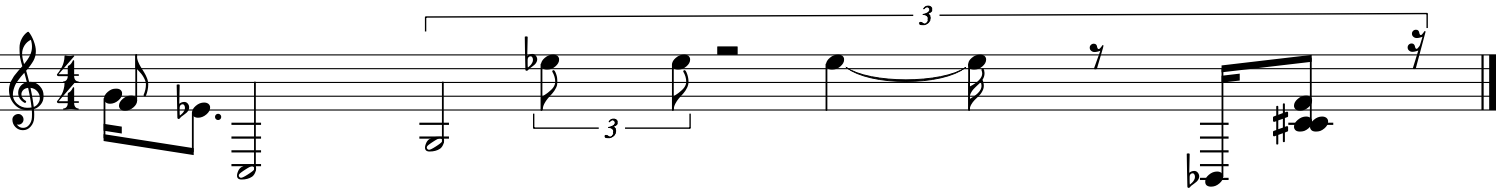

RECONSTRUCTION


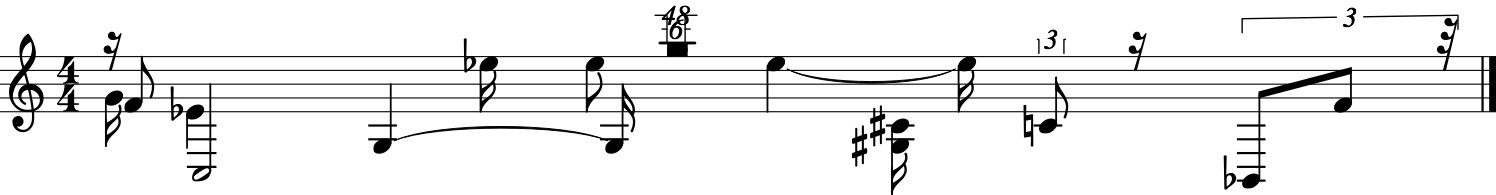

RANDOM NOISE WITH SAME MEAN and VARIANCE


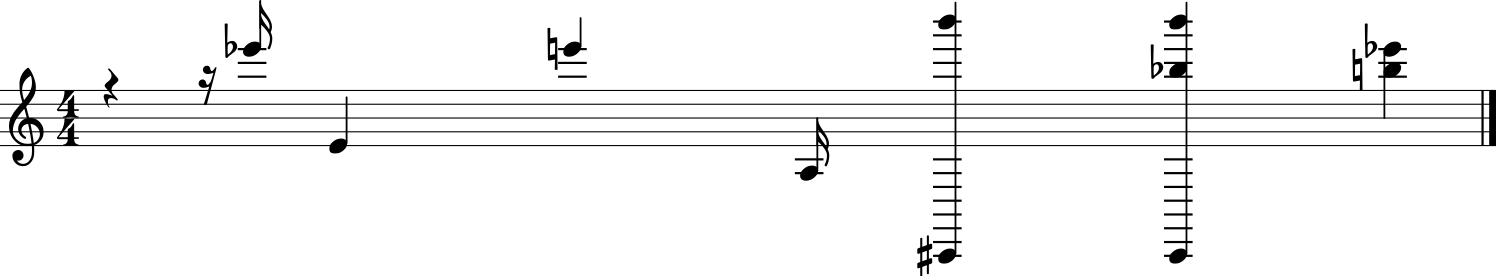




INPUT


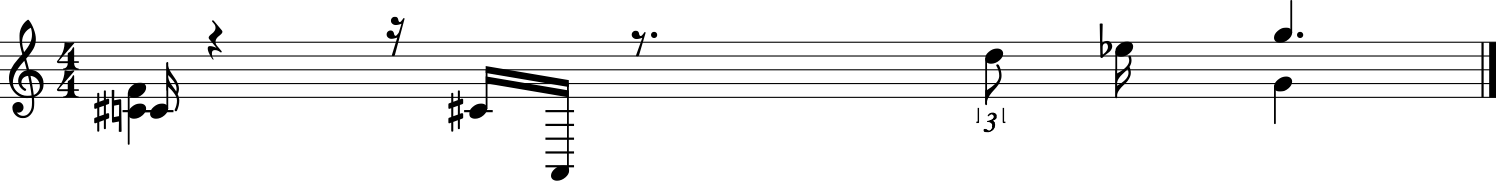

RECONSTRUCTION


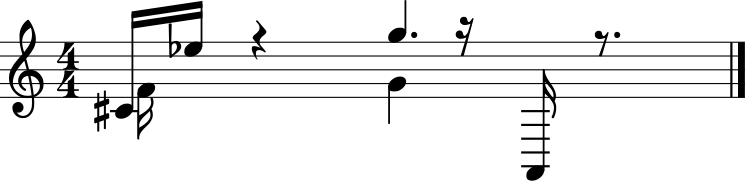

RANDOM NOISE WITH SAME MEAN and VARIANCE


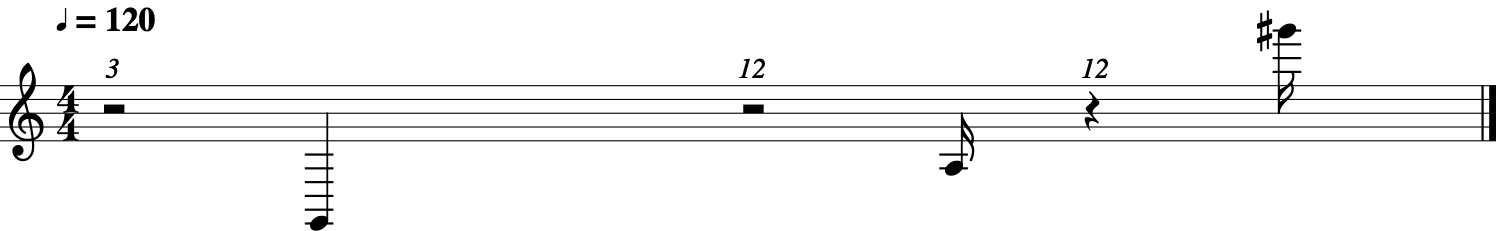




INPUT


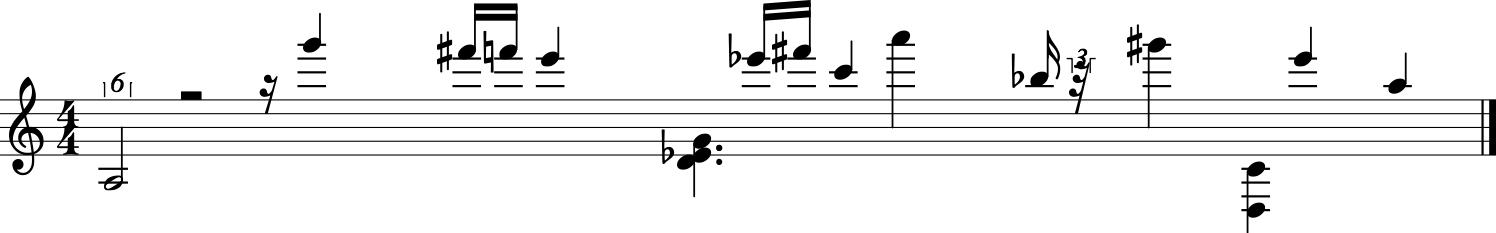

RECONSTRUCTION


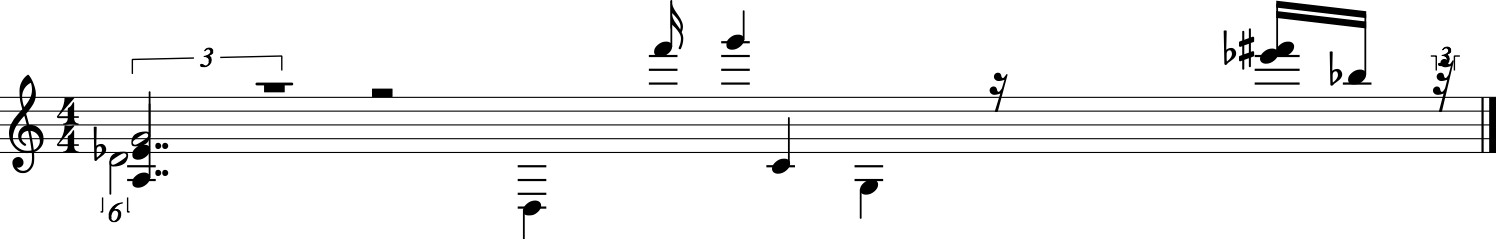

RANDOM NOISE WITH SAME MEAN and VARIANCE


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-f45aa2a08d70>", line 55, in <module>
    showPlayer=True,autoplay=True, prediction=True)
  File "/Users/nw/Uni/tss18-robotsinmusicalimprovisation/utils/utilsPreprocessing.py", line 195, in pianorollMatrixToTempMidi
    score.show()
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/music21/stream/__init__.py", line 258, in show
    return super().show(*args, **kwargs)
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/music21/base.py", line 2578, in show
    **keywords)
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/music21/converter/subConverters.py", line 353, in show
    subformats=helperSubformats, **keywords)
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/music21/convert

SubConverterFileIOException: png file of xml not found. Or file >999 pages?

In [6]:

###PLAY WHOLE SONG IN BARS
with torch.no_grad():
    
    sampleNp1 = getSlicedPianorollMatrixNp(
        "/Users/nw/Uni/DougMcKenzieFiles_noDrums/test/howdsolo.mid")
    for sampleNp in sampleNp1:
        
        if(np.any(sampleNp)):
            #sampleNp = sampleNp[12,:,:]
            #print(sampleNp)
            sampleNp = sampleNp[:,36:-32]
            sample = torch.from_numpy(sampleNp).float()
            
            embed = model.encoder(sample.reshape(1,1,length,reducedPitch).to(device))
            
            noise = torch.randn_like(embed)
            ###HERE YOU CAN ADD THE GAUSSIAN NOISE TO THE RECONSTUCTION
            #embed += noise
            ###TENDS TO ADD RANDOM NOTES WHICH SOUNDS POOR
            recon = model.decoder(embed)
            pred = model.decoder(noise)
            
            reconstruction = recon.squeeze(0).squeeze(0).cpu().numpy()
            prediction = pred.squeeze(0).squeeze(0).cpu().numpy()
            
            #NORMALIZE RECONSTRUCTION/PREDICTIONS
            reconstruction /= np.abs(np.max(reconstruction))
            prediction /= np.abs(np.max(prediction))
            
            
            #CHECK MIDI ACTIVATIONS IN PREDICTION TO INCLUDE RESTS
            reconstruction[reconstruction < 0.3] = 0
            prediction[prediction < 0.8] = 0

            ###MONOPHONIC OUTPUT MATRIX POLOYPHONIC POSSIBLE WITH ACTIVATION THRESHOLD###
            #score = music21.converter.parse(
            #            'WikifoniaServer/samples/The-Doors---Don\'t-you-love-her-Madly?.mid')
            #score.show()

            samplePlay = debinarizeMidi(sampleNp, prediction=False)
            samplePlay = addCuttedOctaves(samplePlay)
            reconstruction = debinarizeMidi(reconstruction, prediction=True)
            reconstruction = addCuttedOctaves(reconstruction)
            prediction = debinarizeMidi(prediction, prediction=True)
            prediction = addCuttedOctaves(prediction)

            print("INPUT")
            pianorollMatrixToTempMidi(samplePlay,show=True,showPlayer=True,autoplay=True)
            print("RECONSTRUCTION")
            pianorollMatrixToTempMidi(reconstruction, show=True,
                                      showPlayer=True,autoplay=True, prediction=True)        
            print("RANDOM NOISE WITH SAME MEAN and VARIANCE")
            pianorollMatrixToTempMidi(prediction, show=True,
                                      showPlayer=True,autoplay=True, prediction=True)
            print("\n\n")
            

print('')